# **Gestión de Proyectos**

##Tarea individual 2 - *Grid, Boosting* y redes neuronales con SciKit-Learn##

###Andrea Azábal Lamoso###

16 de septiembre de 2021

---

#Objetivo

El objetivo de esta práctica es comprobar cómo diferentes métodos de aprendizaje son capaces de trabajar de distinta manera para clasificar una serie de datos a partir de categorías y hacer un *benchmark* de cada una de las técnicas usadas.

Con esta finalidad, se utilizarán técnicas de validación cruzada, en concreto para la obtención de un número óptimo de vecinos K así como la implementación de diferentes *learners* (Redes neuronales, *Ensemble* (*Adaboost*)) sobre dos *dataset* diferentes: uno de dígitos y otro de noticias.


#Preparación del entorno

Instalamos los paquetes necesarios:

In [ ]:
!pip install skranger
!pip install -U nltk
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install scikit-plot
!pip install numpy
!pip install pandas
!pip install statsmodels
!pip install fitter
!pip install graphviz
!pip install xgboost
!pip install lightgbm

     |████████████████████████████████| 465 kB 8.6 MB/s 
     |████████████████████████████████| 22.3 MB 122.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 1.5 MB 8.3 MB/s 
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 47 kB 4.5 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=c10da8e7c7e2129612514288e1ddcd1a06a79152fb8eec1a2c7c54d21b05fccb
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.11.2-py3-none-any.whl size=64232 sha256=2562776026533b2826282adad22584220e082e33b8a08c4658d555b1c223d9f8
  Stored in directo

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import re
import matplotlib.pyplot as plt

#*Digits dataset*

En primer lugar, vamos a trabajar con el *dataset* de *digits* de Scikit-learn. [Según la documentación](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html), el *dataset* de *digits* contiene 1797 puntos, siendo cada uno de ellos una imagen 8x8 (64 atributos en total) de un número entre el 0 y el 9.

    =================   ==============
    Classes                         10
    Samples per class             ~180
    Samples total                 1797
    Dimensionality                  64
    Features             integers 0-16
    =================   ==============

A continuación, se muestra el número de registros para cada una de las clases:

In [ ]:
from sklearn import datasets
#Importamos el dataset
X_digits, y_digits = datasets.load_digits(return_X_y=True)
pd.Series(y_digits).value_counts()

3    183
5    182
1    182
6    181
4    181
9    180
7    179
0    178
2    177
8    174
dtype: int64

Comprobamos que se trata de un *dataset* más o menos balanceado. Nos aseguramos de que no existen valores faltantes:

In [ ]:
np.count_nonzero(np.isnan(y_digits))

0

Procedemos a normalizarlo dividiendo por su valor máximo y creamos los subconjuntos de entrenamiento y prueba:

In [ ]:
#Normalización del dataset
X_digits = X_digits / X_digits.max()
n_samples = len(X_digits)

#Separación en train y test
X_train = X_digits[:int(.8 * n_samples)]
y_train = y_digits[:int(.8 * n_samples)]
X_test = X_digits[int(.8 * n_samples):]
y_test = y_digits[int(.8 * n_samples):]

Vemos que el valor máximo que toman ahora los píxeles es 1:

In [ ]:
#Valor máximo
X_train.max()

1.0

También podemos ver cómo ha quedado dividido el conjunto de datos inicial:

In [ ]:
#Train
print(X_train.shape)

(1437, 64)


In [ ]:
#Test
print(X_test.shape)

(360, 64)


Por último, comprobamos que las categorías en ambos subconjuntos siguen estando más o menos balanceadas y no se está sobrerrepresentando ninguna de ellas:

In [ ]:
#Train
pd.Series(y_train).value_counts()

3    146
1    146
5    145
6    144
4    144
9    143
7    143
0    143
2    142
8    141
dtype: int64

In [ ]:
#Test
pd.Series(y_test).value_counts()

9    37
6    37
5    37
4    37
3    37
7    36
1    36
2    35
0    35
8    33
dtype: int64

También podemos representar gráficamente un dígito de cada categoría para ver cómo se muestran:

In [ ]:
y_u=pd.DataFrame(y_train).drop_duplicates()
X_u=X_train[y_u[0].sort_values().index]

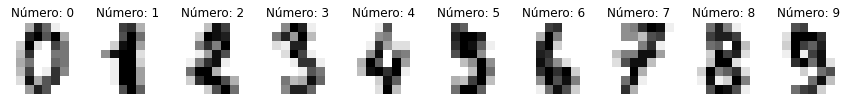

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u, y_u[0].sort_values()):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Número: %i' % label)

Así, se ve cómo las imágenes de ejemplo están muy pixeladas al tener solamente 8x8 píxeles.

##Método KNN

El algoritmo que vamos a implementar en primer lugar para llevar a cabo la predicción es el de los k vecinos más cercanos​. Se trata de un método de clasificación supervisada que estima la probabilidad de que un elemento pertenezca a una determinada clase a partir de la información proporcionada por el conjunto de datos.

El algoritmo calcula distancias en espacios n-dimensionales, siendo  *n*  el número de variables predictoras. Para que KNN funcione bien, precisa de calcular las distancias entre puntos que están en una zona común del espacio. Por esta razón, es necesario realizar un escalado previo de los datos de las variables predictoras.

Así, vamos a valernos de la función ``KNeighborsClassifier`` y ajustar los parámetros más relevantes:

- n_neighbors: número de vecinos cercanos a tener en cuenta para la predicción.

- weights o pesos: ponderación de cada punto.

Además, procedemos a utilizar la función `GridSearchCV` para hallar la mejor especificación del modelo. Así, vamos a probar con los siguientes parámetros:

- k o número de vecinos más próximos: seleccionamos un rango entre 1 y 30.
- *weights* o pesos: si seleccionamos *uniform*, a todos los puntos se les ponderará de igual forma. En cambio, si elegimos *distance*, los puntos más próximos serán más relevantes.
- leaf_size: seleccionamos valores entre 1 y 50.

Además, en la búsqueda vamos a seleccionar `cv=3`, lo cual indica que se va a utilizar el método de *cross validation*, con el objetivo de subdividir el conjunto de entrenamiento en varios *subsets* y conseguir una muestra más representativa de la población. En este caso se ha optado por 3.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

#Generate possible values of the exploration Grid
k = range(1, 30)
weight_options = ['uniform', 'distance']
leaf_size = range(1, 50, 10)

#Infer all the exploratory surface into parameters struct
parameters = dict(n_neighbors=k, weights=weight_options, leaf_size=leaf_size)

#Create Learner Factory
knearest=KNeighborsClassifier()

#Instantiate a GridSearch with the a) Learner Factory b) Exploratory parameters c) CrossValidation param
modelo_knn = GridSearchCV(knearest,parameters,cv=3,scoring='accuracy',return_train_score=True)

#Perform exploratory grid search over TrainingData
modelo_knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': range(1, 50, 10),
                         'n_neighbors': range(1, 30),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

Procedemos a mostrar por pantalla los resultados:

In [ ]:
print(modelo_knn.best_score_)
print(modelo_knn.best_params_)
print(modelo_knn.best_estimator_)

0.9568545581071678
{'leaf_size': 1, 'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


Vemos que el mejor modelo es el que tiene los parámetros `'leaf_size': 1`, ` 'n_neighbors': 1` y `'weights': 'uniform'`, con una precisión de aproximadamente el 95.7%.

Además, por si queremos profundizar en los resultados, reunimos los más relevantes en un *dataframe*:

In [ ]:
results_knn=pd.DataFrame(modelo_knn.cv_results_)
results_knn[['param_n_neighbors','param_leaf_size', 'param_weights', 'mean_test_score', 'mean_fit_time']].sort_values(by=['mean_test_score'], ascending=False)

,param_n_neighbors,param_leaf_size,param_weights,mean_test_score,mean_fit_time
0,1,1,uniform,0.956855,0.010555
235,2,41,distance,0.956855,0.004248
119,2,21,distance,0.956855,0.005443
1,1,1,distance,0.956855,0.009383
174,1,31,uniform,0.956855,0.004316
...,...,...,...,...,...
114,29,11,uniform,0.919276,0.005852
56,29,1,uniform,0.919276,0.009554
172,29,21,uniform,0.919276,0.005196
230,29,31,uniform,0.919276,0.004336


De esta forma vemos que, por ejemplo, el mejor resultado ha tenido un tiempo de ejecución de 0.01 segundos. Además, hay otras opciones con la misma *accuracy*, todas ellas con un bajo número de vecinos más cercanos. Otros datos relevantes son:

In [ ]:
print("Los modelos más imprecisos son:")
results_knn[results_knn.mean_test_score == results_knn.mean_test_score.min()][['param_n_neighbors','param_leaf_size', 'param_weights', 'mean_test_score', 'mean_fit_time']]

Los modelos más imprecisos son:


,param_n_neighbors,param_leaf_size,param_weights,mean_test_score,mean_fit_time
56,29,1,uniform,0.919276,0.009554
114,29,11,uniform,0.919276,0.005852
172,29,21,uniform,0.919276,0.005196
230,29,31,uniform,0.919276,0.004336
288,29,41,uniform,0.919276,0.004263


In [ ]:
print("El modelo más lento es:")
results_knn[results_knn.mean_fit_time == results_knn.mean_fit_time.max()][['param_n_neighbors','param_leaf_size', 'param_weights', 'mean_test_score', 'mean_fit_time']]

El modelo más lento es:


,param_n_neighbors,param_leaf_size,param_weights,mean_test_score,mean_fit_time
34,18,1,uniform,0.92206,0.010948


Así, por ejemplo, comprobamos que el modelo más lento ha tardado 10 veces más que el modelo más impreciso, siendo su *accuracy*, no obstante, casi un 5% superior.

Para ver la evolución de la precisión de manera más intuitiva, creamos la siguiente función, la cual nos va a permitir representar la evolución de la *accuracy* según los parámetros de la implementación:

In [ ]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

Las gráficas que se obtienen son las siguientes:

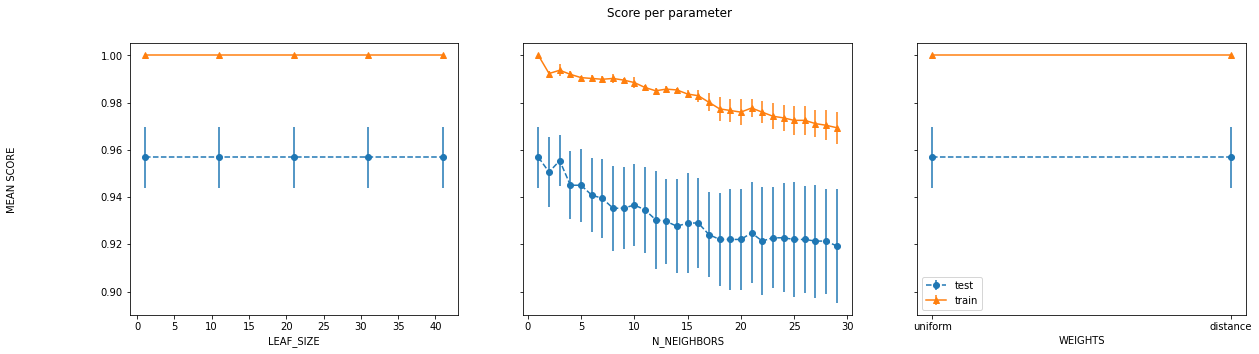

In [ ]:
plot_search_results(modelo_knn)

De esta forma, comprobamos que tanto el parámetro `leaf_size` como el parámetro `weights` son irrelevantes a la hora de escoger el modelo con mayor precisión para este *dataset*, por lo que podemos ignorarlos.

Por otra parte, la precisión sobre el subconjunto de entrenamiento es mayor que para el subconjunto *test* durante la *cross validation*. Esto se debe a que el modelo se ajusta muy bien a los datos sobre los que está aprendiendo, pero luego no es capaz de generalizar tan bien con los datos de prueba.

Asimismo, se observa que a mayor número de vecinos, la precisión tiende a disminuir tanto para el subconjunto de entrenamiento como para el de *test* durante la *cross validation*, teniendo este último un máximo en *k=1* como ya habíamos obtenido. Este hecho se traduce en la presencia de *underfitting* y se debe a que, cuantos más vecinos se tienen en cuenta para el aprendizaje, más imprecisa se vuelve la distinción entre clases. El **número óptimo es, por tanto, $k=1$**.

Por último, una vez conocido el comportamiento sobre el subconjunto de entrenamiento, procedemos a aplicar el modelo sobre el subconjunto de validación (20% del *dataset* original), valiéndonos de nuevo del método de validación cruzada para hallar tanto las predicciones como las precisiones.

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
preds_test_knn = cross_val_predict(modelo_knn, X_test,y_test, cv=3, method="predict", n_jobs=-1)
score_knn = cross_val_score(modelo_knn, X_test,y_test, cv=3, scoring="accuracy")

Los tres resultados devueltos por la *cross validation* son:

In [ ]:
score_knn

array([0.79166667, 0.80833333, 0.93333333])

En promedio se tiene una **precisión** sobre el subconjunto de validación de **aproximadamente un 84%.**

In [ ]:
score_knn.mean()

0.8444444444444444

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          84.4%         |    0.01     |   
 

###Matriz de confusión

A continuación, con el objetivo de averiguar qué números se están clasificando mejor y con cuáles tiene más problemas el algoritmo, creamos la matriz de confusión:

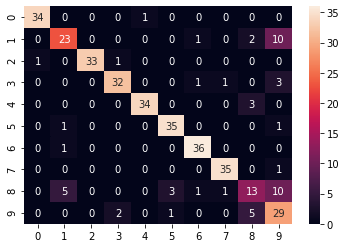

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
matriz=confusion_matrix(y_test, preds_test_knn)
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g'
           )

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que las filas representan la clase real. Así, se ve que el dígito 1 se está clasificando mal, pues en un alto número de ocasiones se está confundiendo con un 9. Lo mismo sucede con el número 8, que también se ha confundido en 5 ocasiones con un 1. Además, de todas las veces que el algoritmo ha predicho un 8, una cantidad significativa de ellas en realidad se trataba de un 9.

En resumen, **el algoritmo tiene dificultades para distinguir los dígitos 1, 8 y 9 entre sí.** Tiene sentido, pues al poseer las imágenes una resolución tan baja, estos dígitos son los menos legibles.

Podemos calcular la *precision* y el *recall* de una de las categorías de la siguiente forma. Si, por ejemplo, nos fijamos en el dígito 1:

$$ Precision_1 =  \frac{TP}{TP+FP} = \frac{23}{23+1+1+5}=0.767 $$ 

$$ Recall_1 =  \frac{TP}{TP+FN}=\frac{23}{23+1+2+10}=0.638$$ 

Por tanto, para esta clase se están generando bastantes falsos negativos pues el *recall* es bajo. De manera análoga, se están dando algunos falsos positivos por lo que la *precision* se ve afectada aunque en menor medida.



### *Classification report*

En esta sección procedemos a aunar todos los resultados de la matriz de confusión para todas las categorías del *dataset* de validación:


In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(y_test, preds_test_knn)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.77      0.64      0.70        36
           2       1.00      0.94      0.97        35
           3       0.91      0.86      0.89        37
           4       0.97      0.92      0.94        37
           5       0.90      0.95      0.92        37
           6       0.92      0.97      0.95        37
           7       0.95      0.97      0.96        36
           8       0.57      0.39      0.46        33
           9       0.54      0.78      0.64        37

    accuracy                           0.84       360
   macro avg       0.85      0.84      0.84       360
weighted avg       0.85      0.84      0.84       360



Se concluye, por tanto, que **mediante el método KNN se tienen dificultades para clasificar los dígitos 1, 8 y 9**, siendo el 8 el dígito que peor *F1 Score* presenta (46%) debido tanto a un bajo *recall* (muchos falsos negativos) como a una baja *precision* (muchos falsos positivos).

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          84.4%         |    0.01     |   

## Red neuronal

Para este segundo método, se propone utilizar como clasificador un perceptrón multicapa con el *learner* `MLPClassifier()`. Los parámetros que vamos a ajustar en esta ocasión con la *Grid Search* son:

- *Solver* u optimizador: especifica la forma en la que se alcanza el mínimo de la función de coste. Hay 3 posibilidades: 

 - ‘lbfgs’

 - ‘sgd’ (*stochastic gradient descent*)

 - ‘adam’ 

- *Learning rate*: tasa de aprendizaje de la red neuronal, un valor demasiado bajo puede causar *underfitting* (el algoritmo no se ajusta lo suficiente a los datos) mientras que un valor excesivamente alto puede evitar que converja. Se seleccionan valores en el intervalo (0,1].

Además, se define `hidden_layer_sizes=(200,)` (una capa de dimensión 200) y `max_iter=500`, es decir, el número máximo de iteraciones o *epochs*. Con todos estos parámetros, se procede a utilizar de nuevo el método de *cross validation* con `cv=3`.


In [ ]:
from sklearn.neural_network import MLPClassifier
#Generate possible values of the exploration Grid
learning_rate = np.linspace(0.1,1,10)
solver=['lbfgs', 'sgd', 'adam']

#Infer all the exploratory surface into parameters struct
parameters = dict(learning_rate_init=learning_rate, solver=solver)

#Create Learner Factory
nn = MLPClassifier(hidden_layer_sizes=(200,), max_iter=500)

#Instantiate a GridSearch with the a) Learner Factory b) Exploratory parameters c) CrossValidation param
modelo_rn = GridSearchCV(nn,parameters,cv=3,scoring='accuracy',return_train_score=True)

#Perform exploratory grid search over TrainingData
modelo_rn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(200,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=

A continuación se muestran los valores más óptimos devueltos por la *Grid Search*:

In [ ]:
print(modelo_rn.best_score_)
print(modelo_rn.best_params_)
print(modelo_rn.best_estimator_)

0.9505915100904664
{'learning_rate_init': 0.7000000000000001, 'solver': 'sgd'}
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.7000000000000001, max_fun=15000,
              max_iter=500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)


Así, el mejor ***learning rate* es 0.7** mientras que el mejor *solver* u optimizador es el ***sdg*** o *Stochastic Gradient Descent*. Almacenamos los detalles en el *dataframe* a continuación:

In [ ]:
results_rn=pd.DataFrame(modelo_rn.cv_results_)
results_rn[['param_learning_rate_init','param_solver',  'mean_test_score', 'mean_fit_time']].sort_values(by=['mean_test_score'], ascending=False)

,param_learning_rate_init,param_solver,mean_test_score,mean_fit_time
19,0.7,sgd,0.950592,0.566488
13,0.5,sgd,0.949896,0.765982
16,0.6,sgd,0.948504,0.590032
2,0.1,adam,0.947808,0.668995
4,0.2,sgd,0.947112,1.489808
7,0.3,sgd,0.947112,1.147975
10,0.4,sgd,0.945720,0.902235
1,0.1,sgd,0.945720,2.221762
0,0.1,lbfgs,0.940153,0.638219
15,0.6,lbfgs,0.939457,0.653895


Comprobamos así que el mejor método tarda 0.57 segundos en ejecutarse, mucho más que en el caso del clasificador KNN con una *accuracy* similar del 95%.

Procedemos a representar la precisión en función de los parámetros de la búsqueda:

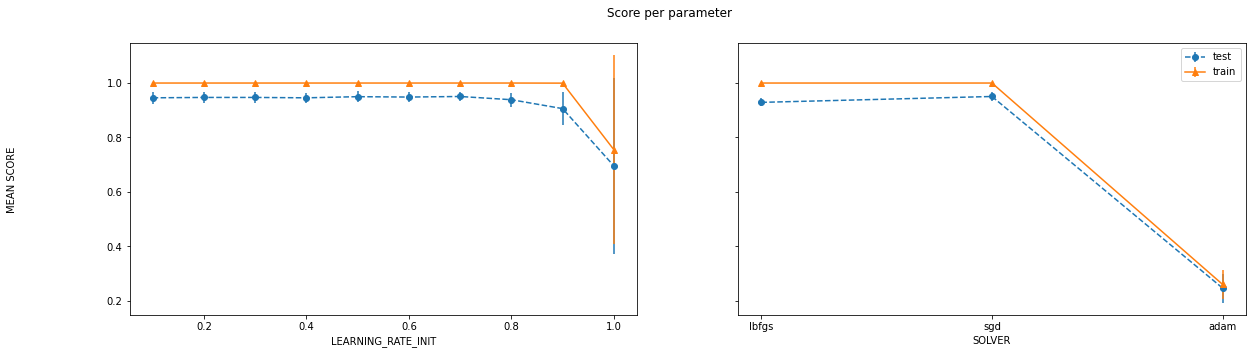

In [ ]:
plot_search_results(modelo_rn)

Vemos que la precisión se mantiene más o menos constante hasta un *learning* *rate* de aproximadamente 0.8. A partir de ahí, tanto la precisión sobre el subconjunto de entrenamiento como sobre el subconjunto de *test* de la validación cruzada disminuyen considerablemente. Es decir, estamos ante la presencia de *underfitting*. Esto probablemente se deba a que, para tasas de aprendizaje tan altas, el descenso del gradiente no es capaz de encontrar un mínimo y oscila demasiado.

Si nos fijamos ahora en el optimizador, vemos que tanto *lbgfs* como *sgd* funcionan bastante bien, siendo la precisión de este último ligeramente superior sobre el subconjunto de prueba. El optimizador *adam*, que es el que se utiliza por defecto, en este caso no es una buena elección y se descarta.

Por último, aplicamos la red entrenada sobre el subconjunto de validación inicial para ver cómo se comporta sobre nuevos *datasets*:

In [ ]:
preds_test_rn = cross_val_predict(modelo_rn, X_test,y_test, cv=3, method="predict", n_jobs=-1)
score_rn = cross_val_score(modelo_rn, X_test,y_test, cv=3, scoring="accuracy")

In [ ]:
score_rn

array([0.73333333, 0.825     , 0.88333333])

Se tiene que **el promedio al realizar una validación cruzada es del 81.4%, inferior a la precisión alcanzada por el método KNN**:

In [ ]:
score_rn.mean()

0.8138888888888888

###Matriz de confusión

A continuación, con el objetivo de averiguar qué números se están clasificando mejor y con cuáles tiene más problemas el algoritmo, generamos la matriz de confusión:

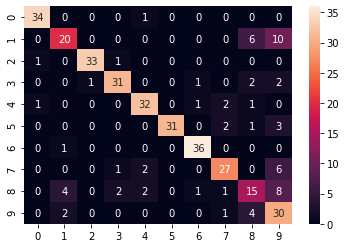

In [ ]:
matriz=confusion_matrix(y_test, preds_test_rn)
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g'
           )

A primera vista, se observa que, de manera similar a lo ocurrido con la modelización anterior, de nuevo los dígitos más problemáticos son **el 1** (con 16 falsos negativos), **el 8** (con 18 falsos negativos y 14 falsos positivos) **y el 9** (con 24 falsos positivos). Se concluye así que este modelo, al igual que el KNN, **tiene dificultades a la hora de distinguir esos tres dígitos** entre sí.

### *Classification report*

En esta sección procedemos a aunar todos los resultados de la matriz de confusión para todas las categorías del *dataset* de validación:

In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(y_test, preds_test_rn)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.74      0.56      0.63        36
           2       0.97      0.94      0.96        35
           3       0.89      0.84      0.86        37
           4       0.86      0.86      0.86        37
           5       1.00      0.84      0.91        37
           6       0.92      0.97      0.95        37
           7       0.82      0.75      0.78        36
           8       0.52      0.45      0.48        33
           9       0.51      0.81      0.62        37

    accuracy                           0.80       360
   macro avg       0.82      0.80      0.80       360
weighted avg       0.82      0.80      0.80       360



Otra vez se confirma que el dígito 8 es el que peor está siendo clasificado, pues más de la mitad de las veces se predice como otro número (*recall* del 45%). Además, de todas las veces que se ha predicho 8, solo la mitad de las veces era correcto. Después del 8, los dígitos 1 y 9 son los que peores resultados arrojan, destacando el alto número de falsos negativos del 1 y el alto número de falsos positivos del 9.

El resto de dígitos tienen un comportamiento bueno, siendo en su mayoría clasificados correctamente.

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          81.4%         |    0.57     |   

## *AdaBoost*

AdaBoost es un algoritmo ensamblado mediante el cual se lanzan varios árboles de decisión en serie tratando de mejorar el ajuste del modelo a los datos de entrenamiento. Así, cada instancia tiene un peso asociado, siendo inicialmente el mismo para todas. Conforme avanza el entrenamiento, los pesos se van modificando de manera que los de las filas mejor estimadas disminuyen y los de las peores predicciones aumentan. A continuación, se vuelve a lanzar un nuevo árbol de decisión. El proceso se repite hasta alcanzar el número máximo de iteraciones.

En este caso, los parámetros que vamos a tratar de ajustar mediante la *Grid Search* son los siguientes:

- *n_estimators*: número de árboles de decisión que se lanzarán en serie. Seleccionamos los valores 200, 300, 400 y 500.
- *Learning rate*: al igual que para la red neuronal, se establece una tasa de aprendizaje que determinará la velocidad con la que se aproximará al mínimo de la función de coste. Se seleccionan valores en el intervalo (0,1].

Además, se define el método de validación cruzada con `cv=3`, es decir, con 3 *subsets*.


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
#Generate possible values of the exploration Grid
n_estimators=range(200,501,100)
learning_rate = np.linspace(0.1,1,10)

#Infer all the exploratory surface into parameters struct
parameters = dict(n_estimators=n_estimators, learning_rate=learning_rate)

#Create Learner Factory
ab = AdaBoostClassifier()

#Instantiate a GridSearch with the a) Learner Factory b) Exploratory parameters c) CrossValidation param
modelo_ab = GridSearchCV(ab,parameters,cv=3,scoring='accuracy',return_train_score=True)

#Perform exploratory grid search over TrainingData
modelo_ab.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'n_estimators': range(200, 501, 100)},
             return_train_score=True, scoring='accuracy')

Una vez entrenado el modelo, comprobamos que la combinación de parámetros más óptima es:

In [ ]:
print(modelo_ab.best_score_)
print(modelo_ab.best_params_)
print(modelo_ab.best_estimator_)

0.8183716075156576
{'learning_rate': 0.5, 'n_estimators': 500}
AdaBoostClassifier(learning_rate=0.5, n_estimators=500)


Es decir, el modelo con `learning_rate': 0.5` y `n_estimators: 500` es el que mayor *accuracy* alcanza: **81.8% sobre el subconjunto de entrenamiento.** En comparación con las otras dos modelizaciones propuestas, esta es la que menos precisión alcanza con diferencia, siendo casi un 15% inferior.

Si recopilamos los resultados de la *Grid Search* en un *dataframe*:

In [ ]:
results_ab=pd.DataFrame(modelo_ab.cv_results_)
results_ab[['param_n_estimators','param_learning_rate','mean_fit_time', 'mean_test_score']].sort_values(by=['mean_test_score'], ascending=False)

,param_n_estimators,param_learning_rate,mean_fit_time,mean_test_score
19,500,0.5,1.811855,0.818372
31,500,0.8,1.809209,0.814196
11,500,0.3,1.790633,0.807237
18,400,0.5,1.442329,0.806541
15,500,0.4,1.788003,0.805150
10,400,0.3,1.426936,0.799582
14,400,0.4,1.410440,0.798887
23,500,0.6,1.801394,0.797495
17,300,0.5,1.062264,0.791232
13,300,0.4,1.061577,0.789144


Comprobamos que el modelo más preciso tarda 1.8 segundos en ajustarse. De hecho, parece que el tiempo de ejecución es directamente proporcional al número de árboles de decisión empleados en el entrenamiento:

In [ ]:
print("200 estimadores:")
results_ab[results_ab.param_n_estimators == 200].mean_fit_time.mean()


200 estimadores:


0.7400383472442627

In [ ]:
print("400 estimadores:")
results_ab[results_ab.param_n_estimators == 400].mean_fit_time.mean()

400 estimadores:


1.4356066942214967

Efectivamente, los tiempos de ejecución aumentan linealmente conforme aumenta el número de árboles de decisión en serie calculados por el modelo. 

Además, podemos representar gráficamente la evolución de la precisión en función de la tasa de aprendizaje y el número de árboles de decisión.

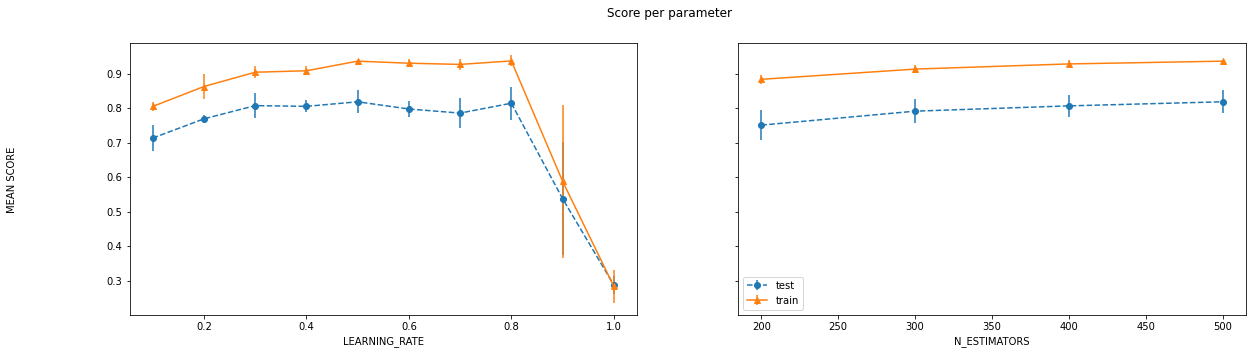

In [ ]:
plot_search_results(modelo_ab)

Como cabía esperar, un mayor número de árboles de decisión supone un mejor ajuste. Si no hay suficientes árboles, el modelo no es capaz de alcanzar el mínimo de la función de coste, por lo que existe un *underfitting*, hecho que estamos observando pues no se ha alcanzado todavía un máximo en la precisión.

Por otra parte, la tasa de aprendizaje o *learning rate* fluctúa bastante para valores inferiores a 0.8, punto a partir del cual sufre una disminución drástica. Este hecho es probablemente debido a que, al ser la tasa de aprendizaje tan grande, el algoritmo oscila en torno al mínimo de la función de coste sin ser capaz alcanzarlo de manera precisa.

Por último, aplicamos el modelo sobre el subconjunto de entrenamiento y calculamos la precisión mediante el método de validación cruzada:

In [ ]:
preds_test_ab = cross_val_predict(modelo_ab, X_test,y_test, cv=3, method="predict", n_jobs=-1)
score_ab = cross_val_score(modelo_ab, X_test,y_test, cv=3, scoring="accuracy")

In [ ]:
score_ab

array([0.68333333, 0.66666667, 0.68333333])

**La precisión promedio del *Ada Boost* sobre el subconjunto de prueba es del 67.8%**.

In [ ]:
score_ab.mean()

0.6777777777777777

###Matriz de confusión

A continuación, con el objetivo de averiguar qué números se están clasificando mejor y con cuáles tiene más problemas el algoritmo, generamos la matriz de confusión:

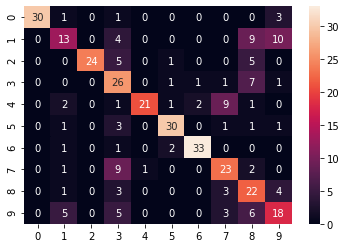

In [ ]:
matriz=confusion_matrix(y_test, preds_test_ab)
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g'
           )

En esta tercera modelización observamos un mayor número de observaciones fuera de la diagonal de la matriz, es decir, **el modelo no es tan buen clasificador como el algoritmo KNN o la red neuronal** propuesta. En concreto, vemos cómo los dígitos 7, 8 y 9 presentan una gran cantidad de falsos positivos. Por su parte, el dígito 1 está siendo clasificado incorrectamente como un 8 o un 9 en la mayoría de casos.

### *Classification report*

En esta sección procedemos a aunar todos los resultados de la matriz de confusión para todas las categorías del *dataset* de validación:


In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(y_test, preds_test_ab)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        35
           1       0.52      0.36      0.43        36
           2       1.00      0.69      0.81        35
           3       0.45      0.70      0.55        37
           4       0.95      0.57      0.71        37
           5       0.86      0.81      0.83        37
           6       0.92      0.89      0.90        37
           7       0.57      0.64      0.61        36
           8       0.42      0.67      0.51        33
           9       0.49      0.49      0.49        37

    accuracy                           0.67       360
   macro avg       0.72      0.67      0.68       360
weighted avg       0.72      0.67      0.68       360



En la tabla se ve que los resultados son muy dispares entre dígitos. Por ejemplo, los dígitos 0 y 2 tienen una *precision* del 100%, indicando que ninguna otra categoría está siendo confundida con las suyas. En el otro extremo están los números 3 y 8, con una *precision* inferior al 50%. 

Cabe destacar, además, que el dígito 1 es el que más problemas presenta a la hora de ser clasificado, puesto que con un *recall* del 36%, prácticamente 2/3 del número total de instancias de esta categoría están siendo incorrectamente clasificadas.

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          67.8%         |    1.8     |   

## Comparación entre modelos

La siguiente tabla recoge los principales resultados alcanzados:

| Algoritmo        | *Accuracy* sobre *test*|  Tiempo(s)  |
|------------------|:----------------------:|:-----------:|
|  KNN             |          84.4%         |    0.01     | 
|  Red neuronal    |          81.4%         |    0.57     |   
|  *AdaBoost*      |          67.8%         |   1.8     | 

De los tres clasificadores implementados, el método KNN es el que presenta mejores resultados (84% de precisión) en un tiempo de ejecución inferior. Le sigue la red neuronal, con una precisión ligeramente inferior (-3%) y un tiempo de ejecución considerablemente más alto. Por último, el método que peores resultados arroja es el ensamblado *AdaBoost*, con un descenso radical de la precisión de aproximadamente un 15%.

Este hecho probablemente se deba a que no hemos seleccionado un número de árboles de decisión lo suficientemente alto para el *AdaBoost*. Además, este algoritmo es más sensible a los conjuntos de datos "ruidosos" que el método KNN, por ejemplo.

En conclusión, el claro **vencedor** a la hora de modelizar el *set* de datos es el método de **K *nearest neighbors* con *k=1***, pues consigue la mayor precisión con un tiempo de ejecución muchísimo más reducido que la red neuronal.

#*20 newsgroups text dataset*

En esta seguna parte de la tarea, vamos a repetir los mismos pasos sobre un nuevo conjunto de datos, *20newsgroups*, el cual comprende alrededor de 18.000 publicaciones de grupos de noticias sobre 20 temas divididos en dos subconjuntos: *training* y *test*.

A continuación se importa el subconjunto de entrenamiento y se muestran las categorías de cada tipo de noticia:




In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


La correspondencia entre cada categoría y su identificador es:

- alt.atheism: 0
- comp.graphics: 1
- comp.os.ms-windows.misc: 2
- comp.sys.ibm.pc.hardware:  
- comp.sys.mac.hardware: 4
- comp.windows.x: 5
- misc.forsale: 6
- rec.autos: 7
- rec.motorcycles: 8
- rec.sport.baseball: 9
- rec.sport.hockey: 10
- sci.crypt: 11
- sci.electronics: 12
- sci.med: 13
- sci.space: 14
- soc.religion.christian: 15
- talk.politics.guns: 16
- talk.politics.mideast: 17
- talk.politics.misc: 18
- talk.religion.misc: 19

Comprobamos que no hay nulos en al subconjunto de entrenamiento:

In [ ]:
pd.DataFrame(newsgroups_train.target).isnull().sum()

0    0
dtype: int64

Por otra parte, comprobamos que hay categorías de noticias que contienen una muestra considerablemente mayor de noticias que otras:

In [ ]:
pd.DataFrame(newsgroups_train.target).value_counts()

10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
dtype: int64

Así, en total hay 11314 instancias en el subconjunto de entrenamiento.

In [ ]:
newsgroups_train.filenames.shape

(11314,)

Por último, nos valemos de `TfidfVectorizer()` para vectorizar los atributos y poder trabajar con las muestras:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)

In [ ]:
vectors.shape

(11314, 101631)

Se repite el mismo procedimiento sobre el subconjunto de prueba:

In [ ]:
newsgroups_test = fetch_20newsgroups(subset='test')
vectors_test = vectorizer.transform(newsgroups_test.data)

Comprobamos que en el subconjunto de entrenamiento existen 7.534 registros:

In [ ]:
vectors_test.shape

(7532, 101631)

Comprobamos que no hay nulos en al subconjunto de validación:

In [ ]:
pd.DataFrame(newsgroups_test.target).isnull().sum()

0    0
dtype: int64

De igual forma, las distintas categorías tambien presentan un desbalance notable en este *subset*:

In [ ]:
pd.DataFrame(newsgroups_test.target).value_counts()

10    399
8     398
15    398
9     397
13    396
7     396
11    396
5     395
2     394
14    394
12    393
3     392
6     390
1     389
4     385
17    376
16    364
0     319
18    310
19    251
dtype: int64

##Método KNN

Comenzamos, de nuevo, entrenando el método de *K nearest neighbors* como clasificador. Para este *dataset*, al haber vectorizado las instancias del conjunto de datos, no es necesario realizar la normalización que sí se llevó a cabo para el *dataset* de *digits*:

In [ ]:
print(vectors)

  (0, 70)	0.10710818409513174
  (0, 1621)	0.05048478633457054
  (0, 2126)	0.11661288826747816
  (0, 2224)	0.0922603829190838
  (0, 2362)	0.33627370633912945
  (0, 2476)	0.1346278818996714
  (0, 2918)	0.08678050128011777
  (0, 2963)	0.09472446806841893
  (0, 4215)	0.04903015241243261
  (0, 4236)	0.025816004726883307
  (0, 4289)	0.10201333563299075
  (0, 4729)	0.03806017753517864
  (0, 4964)	0.05219897871168181
  (0, 5217)	0.01593007970839202
  (0, 5384)	0.07231773328089483
  (0, 5622)	0.043930294370510284
  (0, 6129)	0.04763380958348832
  (0, 6503)	0.020144959348380453
  (0, 7639)	0.021817035554324272
  (0, 8057)	0.07352454384491992
  (0, 8288)	0.10710818409513174
  (0, 10841)	0.07987666689237097
  (0, 11075)	0.05478870477075606
  (0, 11329)	0.04101486592796915
  (0, 11837)	0.06432965559695256
  :	:
  (2033, 29602)	0.2405557556448496
  (2033, 29644)	0.013860800100857015
  (2033, 30320)	0.0971477585076707
  (2033, 30641)	0.03603008394748872
  (2033, 30643)	0.04378526188891377
  (2033, 30

Procedemos a utilizar la función `GridSearchCV` para hallar la mejor especificación del modelo. Así, vamos a probar con los siguientes parámetros:

- k o número de vecinos más próximos: seleccionamos un rango entre 1 y 10.
- *weights* o pesos: si seleccionamos *uniform*, a todos los puntos se les ponderará de igual forma. En cambio, si elegimos *distance*, los puntos más próximos serán más relevantes.

Se ha decidido descartar el parámetro `leafsize` empleado con el *dataset* anterior debido al gran coste computacional que supone sin aportar ninguna mejoría al modelo.

Además, en la búsqueda vamos a seleccionar `cv=3`, lo cual indica que se va a utilizar el método de *cross validation*, con el objetivo de subdividir el conjunto de entrenamiento en varios *subsets* y conseguir una muestra más representativa de la población.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

#Generate possible values of the exploration Grid
k = range(1, 10)
weight_options = ['uniform', 'distance']

#Infer all the exploratory surface into parameters struct
parameters = dict(n_neighbors=k, weights=weight_options)

#Create Learner Factory
knearest=KNeighborsClassifier()

#Instantiate a GridSearch with the a) Learner Factory b) Exploratory parameters c) CrossValidation param
clf = GridSearchCV(knearest,parameters,cv=3,scoring='accuracy',return_train_score=True)

#Perform exploratory grid search over TrainingData
clf.fit(vectors, newsgroups_train.target)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

Una vez ha finalizado la búsqueda, podemos averiguar qué parametrización ha alcanzado una *accuracy* superior:

In [ ]:
print(clf.best_score_)
print(clf.best_params_)
print(clf.best_estimator_)

0.8048436004750211
{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=1)


Vemos que el mejor modelo es el que tiene los parámetros ` 'n_neighbors': 1` y `'weights': 'uniform'`, con una precisión del 80.5%. Este resultado para la parametrización más óptima es **el mismo que se alcanzó con el conjunto de datos de** ***digits***.

Además, por si queremos profundizar en los resultados, reunimos los más relevantes en un *dataframe*:

In [ ]:
results=pd.DataFrame(clf.cv_results_)
results[['param_n_neighbors', 'param_weights', 'mean_test_score', 'mean_fit_time']].sort_values(by=['mean_test_score'], ascending=False)

,param_n_neighbors,param_weights,mean_test_score,mean_fit_time
0,1,uniform,0.804844,0.013628
1,1,distance,0.804844,0.012885
3,2,distance,0.804844,0.012874
5,3,distance,0.794060,0.012830
7,4,distance,0.790966,0.012858
9,5,distance,0.781774,0.012989
11,6,distance,0.777355,0.012688
13,7,distance,0.773996,0.013000
15,8,distance,0.773289,0.012172
17,9,distance,0.769754,0.011876


De esta forma vemos que, por ejemplo, el mejor resultado ha tenido un tiempo de ejecución de 0.01 segundos, exactamente el mismo resultado que se obtuvo para el *dataset* anterior. Además, vemos que hay otras dos opciones más con la misma *accuracy* y tiempos muy similares.

Para verlo de manera más intuitiva,  representamos la evolución de la *accuracy* según los parámetros de la implementación:

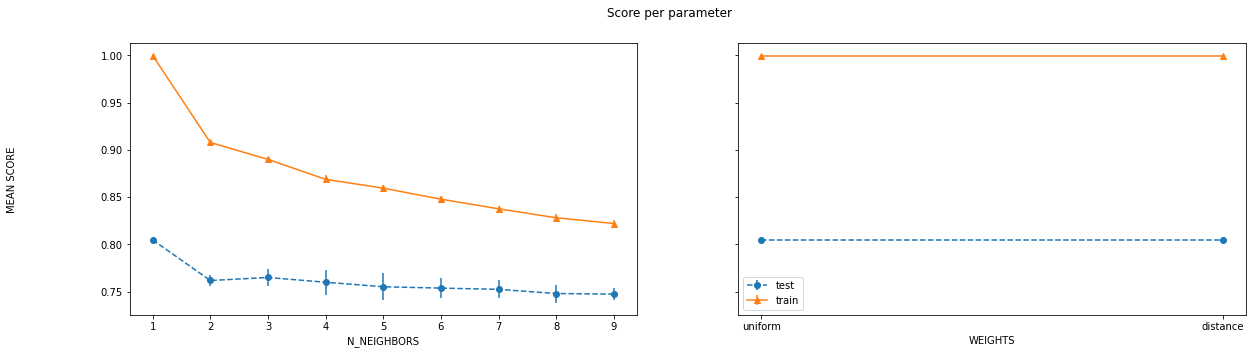

In [ ]:
plot_search_results(clf)

De esta forma, comprobamos que el parámetro `weights` es irrelevante a la hora de escoger el modelo con mayor precisión. Es decir, el hecho de ponderar o no los puntos en función de su distancia no aporta una mejora significativa al modelo. Asimismo, se observa que a mayor número de vecinos, la precisión tiende a disminuir tanto para el subconjunto de entrenamiento como para el de *test* durante la *cross validation*, como es lógico. Este hecho se debe a que, cuantos más vecinos se tienen en cuenta, menos exacta es la predicción, llegando a darse *underfitting* si se seleccionan demasiados.

Por último, una vez conocido el comportamiento sobre el subconjunto de entrenamiento, procedemos a aplicar el modelo sobre el subconjunto de validación, valiéndonos de nuevo del método de validación cruzada para hallar tanto las predicciones como las precisiones.

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
preds_test = cross_val_predict(clf, vectors_test,newsgroups_test.target, cv=2, method="predict", n_jobs=-1)
score = cross_val_score(clf, vectors_test,newsgroups_test.target, cv=2, scoring="accuracy")

In [ ]:
score

array([0.74641529, 0.73659055])

**La precisión promedio sobre el subconjunto de validación es 74.1%,** un 10% inferior a la obtenida mediante la misma parametrización sobre el conjunto de datos *digits*.

In [ ]:
score.mean()

0.7415029208709506

###Matriz de confusión

A continuación, con el objetivo de averiguar qué números se están clasificando mejor y con cuáles tiene más problemas el algoritmo, generamos la matriz de confusión:

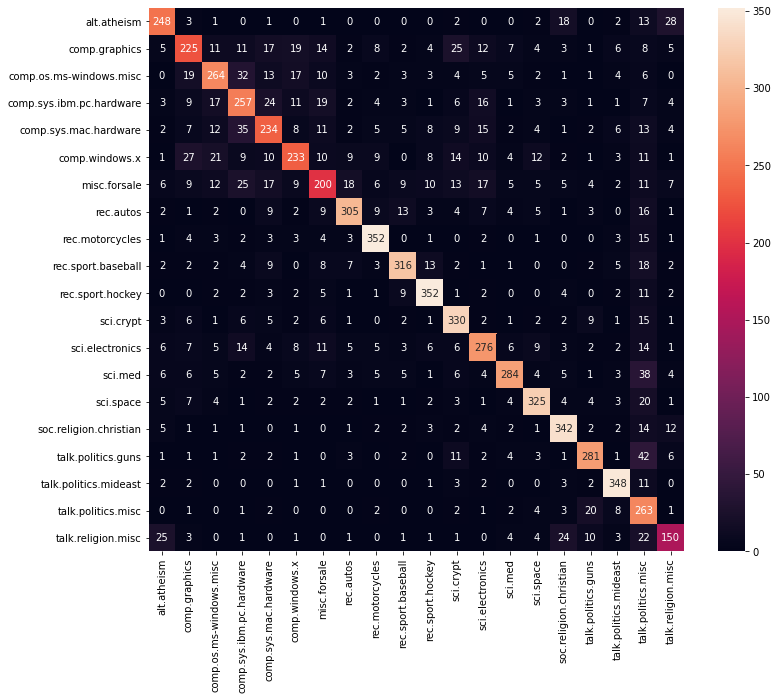

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
matriz=confusion_matrix(newsgroups_test.target, preds_test)
fig, ax = plt.subplots(figsize=(12,10))  
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g'
           , xticklabels=newsgroups_test.target_names,yticklabels=newsgroups_test.target_names
           )

En este caso, es difícil ver a simple vista qué categorías están funcionando mejor y cuáles están funcionando peor. Procedemos por tanto a generar el *classification report*:

### *Classification report*


In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(newsgroups_test.target, preds_test, target_names=newsgroups_test.target_names)}")

Informe de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.77      0.78      0.77       319
           comp.graphics       0.66      0.58      0.62       389
 comp.os.ms-windows.misc       0.73      0.67      0.70       394
comp.sys.ibm.pc.hardware       0.63      0.66      0.64       392
   comp.sys.mac.hardware       0.66      0.61      0.63       385
          comp.windows.x       0.72      0.59      0.65       395
            misc.forsale       0.63      0.51      0.56       390
               rec.autos       0.83      0.77      0.80       396
         rec.motorcycles       0.85      0.88      0.87       398
      rec.sport.baseball       0.84      0.80      0.82       397
        rec.sport.hockey       0.84      0.88      0.86       399
               sci.crypt       0.74      0.83      0.79       396
         sci.electronics       0.73      0.70      0.72       393
                 sci.med       0.85      0.72    

Vemos que la *F1-Score* está entre el 60% y el 80% para la mayoría de categorías. Destaca **talk.politics.mideast** por sus buenos resultados, siendo la categoría que menos falsos positivos y menos falsos negativos arroja (mayor *precision* y *recall*).

Por otra parte, la categoría **misc.forsale** es incorrectamente clasificada en un gran número de casos (*recall* del 51%, es decir, la mitad de las noticias de esta categoría se clasifica como otro tipo).

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          74.2%         |    0.01     |   

## Red neuronal

A continuación, vamos a proceder a implementar una red neuronal con una capa de dimensión 200 igual que la entrenada en el *dataset* anterior. Además, con el fin de poder **comparar el comportamiento al modelizar sobre distintos *datasets***, vamos a seleccionar la **combinación de parámetros que obtuvimos con la *Grid Search* del *dataset* de *digits***, es decir: `learning_rate_init=0.7`, `max_iter = 500` y `solver='sgd'`.

In [ ]:
from sklearn.neural_network import MLPClassifier

clf2 = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.7, max_fun=15000,
              max_iter=500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

clf2.fit(vectors, newsgroups_train.target)

MLPClassifier(hidden_layer_sizes=(200,), learning_rate_init=0.7000000000000001,
              max_iter=500, solver='sgd')

Una vez ajustado el modelo, obtenemos la precisión sobre el subconjunto de entrenamiento gracias al método de validación cruzada:

In [ ]:
score2_train = cross_val_score(clf2, vectors, newsgroups_train.target, cv=2, scoring="accuracy")

In [ ]:
score2_train

array([0.89641153, 0.88173944])

Vemos que la precisión alcanzada para dicho subconjunto es del 89%. Procedemos ahora a averiguar la capacidad de generalización el modelo, calculando la *accuracy* sobre el subconjunto de prueba:

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
preds_test2 = cross_val_predict(clf2, vectors_test,newsgroups_test.target, cv=2, method="predict", n_jobs=-1)
score2 = cross_val_score(clf2, vectors_test,newsgroups_test.target, cv=2, scoring="accuracy")

In [ ]:
score2

array([0.87758895, 0.89166224])

Vemos que se obtiene un resultado muy similar al alcanzado sobre el ***subset* de *training*: 88.4%**. Este resultado supera considerablemente todos los obtenidos hasta ahora, si bien el coste computacional es muy superior al empleado en las modelizaciones previas.

In [ ]:
score2.mean()

0.8846255974508763

###Matriz de confusión

A continuación, con el objetivo de averiguar qué noticias se están clasificando mejor y con cuáles tiene más problemas el algoritmo, creamos la matriz de confusión:

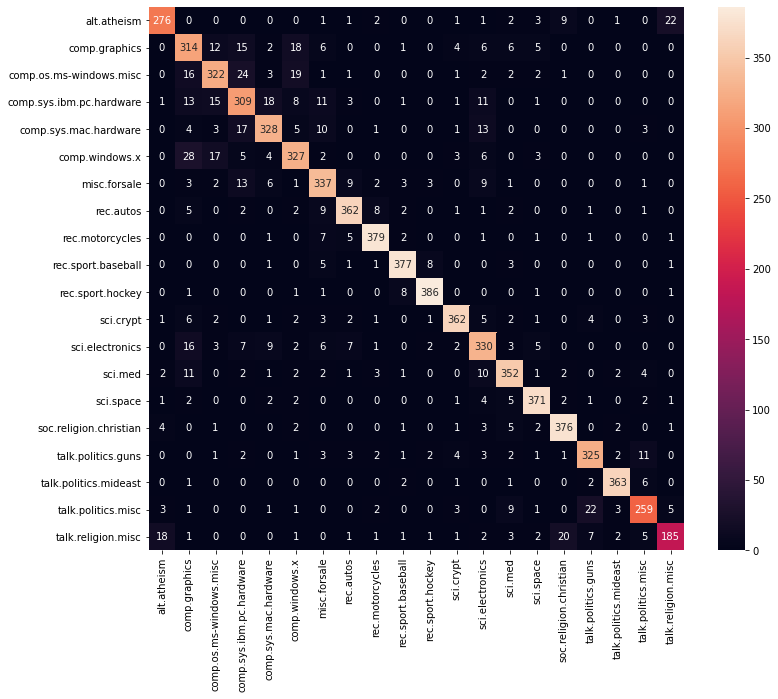

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
matriz=confusion_matrix(newsgroups_test.target, preds_test2)
fig, ax = plt.subplots(figsize=(12,10)) 
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g'
           , xticklabels=newsgroups_test.target_names,yticklabels=newsgroups_test.target_names
           )

Como cabía esperar tras el buen dato para la *accuracy* del modelo, la matriz de confusión tiene muy pocas observaciones fuera de la diagonal, lo cual implica un buen desempeño de la red neuronal como clasificador de noticias.

### *Classification report*

En esta sección procedemos a aunar todos los resultados de la matriz de confusión para todas las categorías del *dataset* de validación:


In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(newsgroups_test.target, preds_test2,target_names=newsgroups_test.target_names)}")

Informe de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.90      0.87      0.88       319
           comp.graphics       0.74      0.81      0.77       389
 comp.os.ms-windows.misc       0.85      0.82      0.83       394
comp.sys.ibm.pc.hardware       0.78      0.79      0.78       392
   comp.sys.mac.hardware       0.87      0.85      0.86       385
          comp.windows.x       0.83      0.83      0.83       395
            misc.forsale       0.83      0.86      0.85       390
               rec.autos       0.91      0.91      0.91       396
         rec.motorcycles       0.94      0.95      0.95       398
      rec.sport.baseball       0.94      0.95      0.95       397
        rec.sport.hockey       0.96      0.97      0.96       399
               sci.crypt       0.94      0.91      0.92       396
         sci.electronics       0.81      0.84      0.82       393
                 sci.med       0.88      0.89    

En la tabla se puede comprobar que la *F1 Score* va desde el 77% para la categoría **comp.graphics** hasta el 97% para **talk.politics.mideast**. Si recordamos, esta última clase era también la que mejores resultados alcanzaba en el modelo KNN. 

En general, se concluye que la red neuronal de una sola capa con 200 neuronas es un buen clasificador para este tipo de conjunto de datos, si bien el coste computacional es abismalmente superior en comparación con el método KNN.

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          88.5%         |    2600     |   

## *AdaBoost*

En este caso, con el fin de poder comparar el desempeño del mismo modelo en distintos *datasets*, **los parámetros que vamos a definir son los mismos que para el conjunto de datos anterior** (*digits*): `learning_rate=0.5, n_estimators=500`.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf3 = AdaBoostClassifier(learning_rate=0.5, n_estimators=500)
clf3.fit(vectors, newsgroups_train.target)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=500, random_state=None)

Una vez generado el modelo, calculamos la *accuracy* sobre el subconjunto de entrenamiento mediante el método de *cross validation*:

In [ ]:
score3_train = cross_val_score(clf3, vectors, newsgroups_train.target, cv=2, scoring="accuracy")

In [ ]:
score3_train

array([0.43627364, 0.47357256])

In [ ]:
score3_train.mean()

0.4549231041187909

Observamos que el resultado, 45.5%, es muy pobre incluso sobre el *training set*.

Por último, procedemos a calcular la *accuracy* sobre el subconjunto de prueba:

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score
preds_test3 = cross_val_predict(clf3, vectors_test,newsgroups_test.target, cv=2, method="predict", n_jobs=-1)
score3 = cross_val_score(clf3, vectors_test,newsgroups_test.target, cv=2, scoring="accuracy")

In [ ]:
score3

array([0.36271907, 0.40971853])

**La precisión promedio en este caso no alcanza el 40%.**

In [ ]:
score3.mean()

0.386218799787573

En comparación con los modelos anteriores, **el algoritmo ensamblado no es ni el más rápido ni el más preciso**. Esto concuerda con las conclusiones alcanzadas para el anterior *dataset*, pues en aquel caso *AdaBoost* fue también el peor clasificador, aunque la discrepancia no fue tan marcada.

###Matriz de confusión

A continuación, con el objetivo de averiguar qué noticias se están clasificando mejor y con cuáles tiene más problemas el algoritmo, creamos la matriz de confusión:

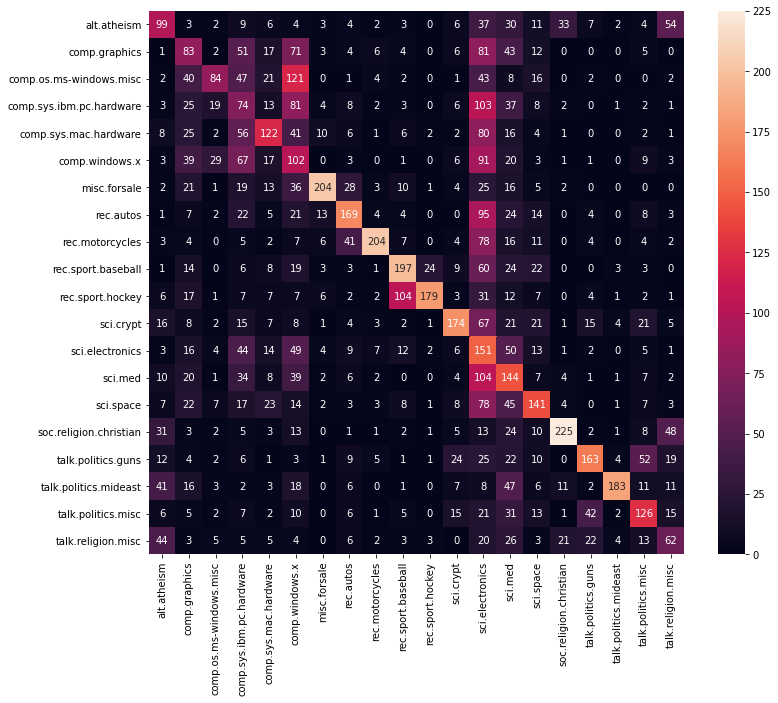

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
matriz=confusion_matrix(newsgroups_test.target, preds_test3)
fig, ax = plt.subplots(figsize=(12,10))
sn.heatmap(pd.DataFrame(matriz), 
           annot=True,fmt='g'
           , xticklabels=newsgroups_test.target_names,yticklabels=newsgroups_test.target_names
           )

En la matriz, llama la atención la cantidad de falsos positivos de la categoría **sci.electronics**, así como **comp.windows.x**. En contraposición, los modelos anteriores no tuvieron grandes dificultades con las categorías relacionadas con electrónica y ordenadores.

### *Classification report*

En esta sección procedemos a aunar todos los resultados de la matriz de confusión para todas las categorías del *dataset* de validación:


In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(newsgroups_test.target, preds_test3,target_names=newsgroups_test.target_names)}")

Informe de Clasificación:
                          precision    recall  f1-score   support

             alt.atheism       0.33      0.31      0.32       319
           comp.graphics       0.22      0.21      0.22       389
 comp.os.ms-windows.misc       0.49      0.21      0.30       394
comp.sys.ibm.pc.hardware       0.15      0.19      0.17       392
   comp.sys.mac.hardware       0.41      0.32      0.36       385
          comp.windows.x       0.15      0.26      0.19       395
            misc.forsale       0.78      0.52      0.63       390
               rec.autos       0.53      0.43      0.47       396
         rec.motorcycles       0.81      0.51      0.63       398
      rec.sport.baseball       0.53      0.50      0.51       397
        rec.sport.hockey       0.83      0.45      0.58       399
               sci.crypt       0.60      0.44      0.51       396
         sci.electronics       0.12      0.38      0.19       393
                 sci.med       0.22      0.36    

Profundizando en los resultados del clasificador, observamos un desempeño generalmente muy pobre, habiendo grandes discrepancias entre unas categorías y otras.

Entre las clases que mejor son clasificadas se encuentran **soc.religion.christian**, **talk.politics.mideast** y **rec.motorcycles**. A pesar de ser las que tienen un mayor *F1 score* (superando el 60%), todas ellas presentan valores bastante pobres para el *recall*. Es decir, las noticias de estas tres categorías están siendo clasificadas como noticias de otro tipo en un gran número de instancias.

Por el contrario, las noticias con un peor desempeño son **comp.sys.ibm.pc.hardware**, **comp.windows.x** y **sci.electronics**, todas ellas con un *F1 Score* inferior al 20%. Estas categorías abarcan noticias tecnológicas relacionadas con la computación y, si nos fijamos de nuevo en la matriz de confusión, comprobamos que están siendo mezcladas entre sí a la hora de ser clasificadas por el algoritmo.

| *Accuracy* sobre *test*|  Tiempo(s)  |
|:----------------------:|:-----------:|
|          38.6%         |    180      |   

## Comparación entre modelos

La siguiente tabla recoge los principales resultados alcanzados en esta sección:

| Algoritmo        | *Accuracy* sobre *test*|  Tiempo(s)  |
|------------------|:----------------------:|:-----------:|
|  KNN             |          74.2%         |    0.01     |  
|  Red neuronal    |         88.5%          |    2600     |   
|  *AdaBoost*      |          38.6%         |    180      |

El algoritmo **más preciso** es, por tanto, la **red neuronal**. Sin embargo, la implementación de este modelo acarrea un gran coste computacional ya que los tiempos de ejecución son varios órdenes de magnitud superiores a los del método KNN. A la hora de elegir entre ámbos métodos, habrá que tener en cuenta los beneficios y costes de cada uno de ellos. Si nuestras necesidades implican la máxima precisión, deberemos adoptar la red mientras que si lo que buscamos es un clasificador rápido, optaremos por el KNN.

Además, al igual que sucedía con el *dataset* de *digits*, **el algoritmo ensamblado queda descartado** debido a su bajo rendimiento.

# Conclusiones finales

A lo largo de esta tarea, se han realizado un total de 6 implementaciones de 3 algoritmos diferentes sobre dos conjuntos de datos. En todas ellas se ha utilizado una *Grid Search* con la finalidad de averiguar la combinación de parámetros más óptima. Además, en todos los casos se han realizado los cálculos mediante el método de validación cruzada.

A continuación se recogen los principales resultados:

| Algoritmo  |*Dataset*|*Accuracy* (*train*)| *Accuracy* (*test*)|Tiempo(s)|
|------------|---------|:------------------:|:------------------:|:-------:|
|KNN         |*Digits* |          95.7%     |  84.4%             |   0.01 | 
|Red neuronal|*Digits* |          95.0%     |  81.4%             |   0.57 |   
|*AdaBoost*  |*Digits* |         81.8%      |  67.8%             | 1.8    |
|KNN         |*20News* |          80.5%     |  74.2%             | 0.01   | 
|Red neuronal|*20News* |          88.9%     |  88.5%             | 2600   |   
|*AdaBoost*  |*20News* |         45.5%      |  38.6%             | 180    |  

###¿Cómo afecta el *learner* a la eficacia de los resultados? ¿Cómo cambia la eficacia del *learner* en función del *set* de datos?

Tras haber aplicado los mismos 3 algoritmos sobre dos conjuntos de datos diferentes, vemos que cada método implementado arroja resultados muy dispares tanto en precisión como en eficiencia. Así, para un mismo problema, es decir, trabajando sobre el mismo *dataset*, hemos comprobado que el método más rápido es con mucha diferencia KNN. 

Sin embargo, dependiendo del problema al que se aplique, el modelo KNN no es el más preciso a la hora de clasificar. Se tiene que, trabajando sobre un subconjunto más simple y reducido de apenas 64 atributos, este método es el que mayor precisión consigue alcanzar, superando ligeramente (3%) a la red neuronal.

Por su parte, la red neuronal funciona muy bien en ambos *datasets*, superando el 80% de *accuracy* al ser aplicada sobre los dos subconjuntos de prueba. No obstante, el principal inconveniente de este método de aprendizaje automático es el coste computacional que acarrea. Así, implementando una única capa de dimensión 200, hemos comprobado que los tiempos de ejecución aumentan exponencialmente con el número de instancias del *subset* de entrenamiento, llegando a tardar más de 40 minutos en el segundo *dataset*, esto es, 3 órdenes de magnitud más que en el primer problema.

Por último, el algoritmo ensamblado *AdaBoost* es el que peores resultados alcanza en ambas casuísticas. En concreto, para el segundo problema apenas somos capaces de clasificar correctamente el 40% de las observaciones. En cuanto a tiempos de ejecución, estos dependen del tamaño del conjunto de datos, pero no de manera tan pronunciada como en el caso de la red neuronal.  

En definitiva, si lo que se busca es un **método eficiente que aporte una buena precisión con un bajo coste computacional**, se debe seleccionar el método **KNN**. Este método es además muy fácilmente parametrizable. Si no nos penaliza el coste computacional, entonces puede ser una buena idea implementar la **red neuronal**, sobre todo para ***datasets* más complejos** en los que KNN no es capaz de ajustarse lo suficiente. 